<a href="https://colab.research.google.com/github/peterbabulik/QSPC/blob/main/HamiltonianLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Theory Generator Loaded.

📡 EXPERIMENTAL DATA COLLECTED.
   - Observable Values (Z0, Z1): [0.31532237 0.31532237]
   - (Hidden Truth: Coupling = 1.25)

🧪 STARTING HAMILTONIAN LEARNING...
   - Initial Guess: Standard Model is perfect (Correction = 0.0)
   Step 0: Loss = 0.101232 | Estimated Coupling = 1.0500
   Step 20: Loss = 0.002781 | Estimated Coupling = 1.2025
   Step 40: Loss = 0.000096 | Estimated Coupling = 1.2511
   Step 60: Loss = 0.000060 | Estimated Coupling = 1.2536
   Step 80: Loss = 0.000007 | Estimated Coupling = 1.2510
   Step 100: Loss = 0.000000 | Estimated Coupling = 1.2498

✅ DISCOVERY COMPLETE.
   ------------------------------------------
   Standard Model Prediction : 1.0000
   True Physical Constant    : 1.2500
   AI-Discovery Value        : 1.2498
   Accuracy                  : 99.99%
   ------------------------------------------


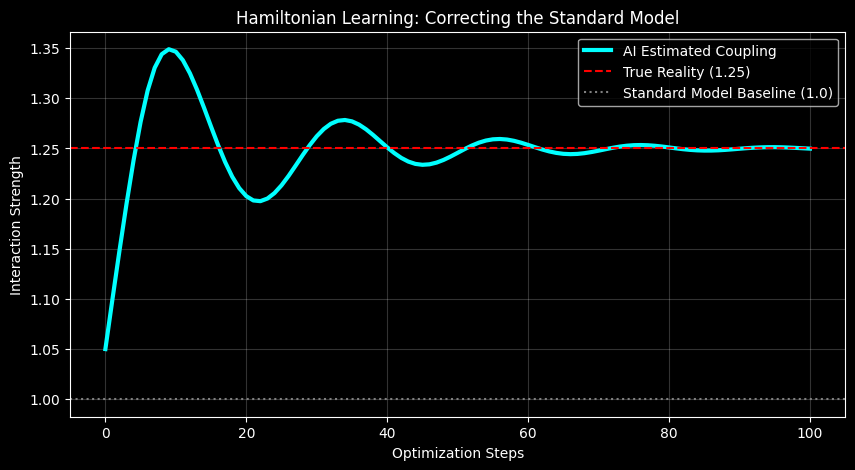

In [2]:
import subprocess
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. INSTALL DEPENDENCIES
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import pennylane as qml
except ImportError:
    install("pennylane")
    import pennylane as qml

from torch.nn import Module, Parameter
from torch.optim import Adam

print("✅ Theory Generator Loaded.")

# ==========================================
# 1. DEFINE REALITY (The Hidden Hamiltonian)
# ==========================================

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# The "True" Constant of Nature (Hidden)
# Standard Model predicts 1.0. Reality is 1.25.
TRUE_INTERACTION_STRENGTH = 1.25

@qml.qnode(dev)
def real_experiment_circuit(coupling_strength):
    # FIX: Start in |00> (Vacuum State) instead of |++>
    # This ensures the IsingXX gate creates distinct, measurable entanglement.

    # The Physical Interaction (Hamiltonian evolution)
    qml.IsingXX(coupling_strength, wires=[0, 1])

    # Measure Z-axis (Population) to detect the rotation
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

# Generate the "Experimental Data"
experimental_observables = torch.tensor(real_experiment_circuit(TRUE_INTERACTION_STRENGTH), dtype=torch.float32)

print(f"\n📡 EXPERIMENTAL DATA COLLECTED.")
print(f"   - Observable Values (Z0, Z1): {experimental_observables.numpy()}")
print(f"   - (Hidden Truth: Coupling = {TRUE_INTERACTION_STRENGTH})")

# ==========================================
# 2. THE THEORETICAL MODEL (Standard Model + Correction)
# ==========================================

@qml.qnode(dev, interface="torch")
def theory_circuit(delta_param):
    # Same initialization as experiment
    # No gates = |00>

    standard_model_coupling = 1.0
    total_coupling = standard_model_coupling + delta_param

    qml.IsingXX(total_coupling, wires=[0, 1])

    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

class TheoryGenerator(Module):
    def __init__(self):
        super().__init__()
        # Initialize "New Physics" correction to 0
        self.delta_correction = Parameter(torch.tensor(0.0, requires_grad=True))

    def forward(self):
        return theory_circuit(self.delta_correction)

# ==========================================
# 3. THE DISCOVERY PROCESS (Training)
# ==========================================

model = TheoryGenerator()
optimizer = Adam(model.parameters(), lr=0.05)

print("\n🧪 STARTING HAMILTONIAN LEARNING...")
print("   - Initial Guess: Standard Model is perfect (Correction = 0.0)")

history_loss = []
history_param = []

for step in range(101):
    optimizer.zero_grad()

    # 1. Predict Physics
    predicted_observables = model()
    predicted_stack = torch.stack(predicted_observables)

    # 2. Compare with Reality
    loss = torch.sum((predicted_stack - experimental_observables) ** 2)

    # 3. Backpropagate
    loss.backward()
    optimizer.step()

    # Track
    current_correction = model.delta_correction.item()
    total_coupling = 1.0 + current_correction

    history_loss.append(loss.item())
    history_param.append(total_coupling)

    if step % 20 == 0:
        print(f"   Step {step}: Loss = {loss.item():.6f} | Estimated Coupling = {total_coupling:.4f}")

# ==========================================
# 4. VISUALIZATION
# ==========================================

print("\n✅ DISCOVERY COMPLETE.")
final_value = 1.0 + model.delta_correction.item()
error_margin = abs(final_value - TRUE_INTERACTION_STRENGTH)

print(f"   ------------------------------------------")
print(f"   Standard Model Prediction : 1.0000")
print(f"   True Physical Constant    : {TRUE_INTERACTION_STRENGTH:.4f}")
print(f"   AI-Discovery Value        : {final_value:.4f}")
print(f"   Accuracy                  : {100 - (error_margin/TRUE_INTERACTION_STRENGTH*100):.2f}%")
print(f"   ------------------------------------------")

plt.figure(figsize=(10, 5))
plt.style.use('dark_background')

plt.plot(history_param, color='cyan', linewidth=3, label='AI Estimated Coupling')
plt.axhline(y=TRUE_INTERACTION_STRENGTH, color='red', linestyle='--', label='True Reality (1.25)')
plt.axhline(y=1.0, color='gray', linestyle=':', label='Standard Model Baseline (1.0)')

plt.title("Hamiltonian Learning: Correcting the Standard Model")
plt.xlabel("Optimization Steps")
plt.ylabel("Interaction Strength")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()